### Standard GCN
As in Kipf et al. (2016)

In [23]:
import sys
import os
import time
import argparse
import pdb

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Add higher directory to python modules path.
sys.path.append("..") 
from dataloader import load_cora
from model import GCN

In [24]:
class obj(object):
    def __init__(self, d):
        for a, b in d.items():
            if isinstance(b, (list, tuple)):
               setattr(self, a, [obj(x) if isinstance(x, dict) else x for x in b])
            else:
               setattr(self, a, obj(b) if isinstance(b, dict) else b)
args = {
    'gpu': 1,
    'seed': None,
    'epochs': 500,
    'lr': 0.01,
    'wd': 5e-4,
    'layers': 2,
    'h_size': 16,
    'dropout': 0.5,
    'val_every': -1,
    'val_only': 1,
    'checkpoint': 0,
    'model': 'save/model-val-0.8233.pth',
    'log_every': 50,
    'prepro': '../data/cora/preprocessed.pth',
    'test': 0,
}
args = obj(args)

In [25]:
def dense_to_sparse(x):
    indices = torch.nonzero(x).t()
    values = x[indices[0], indices[1]] # modify this based on dimensionality
    return torch.sparse.FloatTensor(indices, values, x.size())

In [26]:
# Setup
start = time.time()
args.gpu = args.gpu and torch.cuda.is_available() and False
if args.seed is not None:
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

# Data
if args.prepro:
    tmp = torch.load(args.prepro)
    adj_i, adj_v, adj_s, feats, labels, idx_train, idx_val, idx_test = tmp
    adj = torch.sparse.FloatTensor(adj_i, adj_v, adj_s)
else:
    adj, feats, labels, idx_train, idx_val, idx_test = load_cora()

In [45]:
# Model
model = GCN(num_layers=args.layers, 
            in_size=feats.shape[1],
            h_size=args.h_size, 
            out_size=labels.max().item() + 1,
            dropout=0.4,
            mc_dropout=True)
if args.model:
    model.load_state_dict(torch.load(args.model))

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)

# GPU
if args.gpu:
    tmp = model, adj, feats, labels, idx_train, idx_val, idx_test
    tmp = [x.cuda() for x in tmp]
    model, adj, feats, labels, idx_train, idx_val, idx_test = tmp

In [46]:
from train import train

train(model, optimizer, adj, feats, labels, idx_train, idx_val, args)

Epoch     1 		| 	Train loss: 0.3888 	Train acc: 0.9643	Time: 0.02
Epoch    51 		| 	Train loss: 0.2384 	Train acc: 0.9786	Time: 0.02
Epoch   101 		| 	Train loss: 0.1846 	Train acc: 0.9929	Time: 0.01
Epoch   151 		| 	Train loss: 0.1580 	Train acc: 0.9929	Time: 0.01
Epoch   201 		| 	Train loss: 0.1448 	Train acc: 1.0000	Time: 0.01
Epoch   251 		| 	Train loss: 0.1380 	Train acc: 1.0000	Time: 0.01
Epoch   301 		| 	Train loss: 0.1344 	Train acc: 1.0000	Time: 0.01
Epoch   351 		| 	Train loss: 0.1324 	Train acc: 1.0000	Time: 0.01
Epoch   401 		| 	Train loss: 0.1312 	Train acc: 1.0000	Time: 0.01
Epoch   451 		| 	Train loss: 0.1306 	Train acc: 1.0000	Time: 0.01
Val acc: 	0.7033	| 	Valid loss: 1.0236


(tensor(1.0236, grad_fn=<NllLossBackward>), tensor(0.7033))

In [29]:
import torch.nn.functional as F 

# Data for validation/plotting 
idx = idx_test #torch.cat((idx_val, idx_test))

# Validation
model.eval()
output = model(feats, adj)
y_hat, y = (output[idx], labels[idx]) # helper
loss = F.cross_entropy(y_hat, y)
preds = y_hat.max(1)[1].type_as(y)
preds_eq = preds.eq(y)
acc = preds_eq.float().sum() / len(y)
print(acc)

tensor(0.7780)


#### Confidence

In [20]:
import matplotlib.pyplot as plt

In [21]:
model = GCN(num_layers=2, in_size=feats.shape[1], h_size=16, out_size=labels.max().item() + 1, dropout=0.0)
model.load_state_dict(torch.load('save/model-val-0.8233.pth')) # dropout: 'checkpoint/model-val-0.8033.pth'

In [42]:
import torch.nn.functional as F 
# Data for validation/plotting 
idx = idx_test
# Validation
model.eval()
output = model(feats, adj)
y_hat, y = (output[idx], labels[idx]) # helper
loss = F.cross_entropy(y_hat, y)
preds = y_hat.max(1)[1].type_as(y)
preds_eq = preds.eq(y)
acc = preds_eq.float().sum() / len(y)
print('Loss: ', loss.item())
print('Acc: ', acc.item())

Loss:  1.5806583166122437
Acc:  0.550000011920929


In [43]:
probs = torch.softmax(y_hat, dim=1)
correct = probs.reshape(-1)[(probs * torch.eye(7)[labels[idx]]).reshape(-1).nonzero()]
incorrect = probs.reshape(-1)[(probs * (1-torch.eye(7)[labels[idx]])).reshape(-1).nonzero()]
conf_max = probs.max(1)[0]
# correct = conf_max[probs.max(1)[1] == labels[idx]]
# incorrect = conf_max[probs.max(1)[1] != labels[idx]]

# Set up histogram
buckets = 20
bucket_ranges = np.arange(buckets + 1) / buckets

# Histogram
hist_correct = np.zeros(buckets)
hist_total = np.zeros(buckets)
for j in range(buckets):
    for conf in correct:
        if bucket_ranges[j] < conf.detach() < bucket_ranges[j+1]:
            hist_correct[j] += 1
            hist_total[j] += 1
    for conf in incorrect:
        if bucket_ranges[j] < conf.detach() < bucket_ranges[j+1]:
            hist_total[j] += 1
            
ratio = np.nan_to_num(hist_correct/hist_total, 0)

In [44]:
ece = 0 
for idx, cor in enumerate(hist_correct):
    print(cor / hist_total[idx],(idx * 0.05 + 0.025))
    ece += hist_total[idx] / sum(hist_total) * np.abs(cor / hist_total[idx] - (idx * 0.05 + 0.025))
    print(ece)

0.04510599909788002 0.025
0.012735714285714284
0.11904761904761904 0.07500000000000001
0.016435714285714283
0.11486486486486487 0.125
0.01686428571428571
0.19298245614035087 0.17500000000000002
0.017449999999999993
0.17297297297297298 0.225
0.018824999999999995
0.20588235294117646 0.275
0.020167857142857137
0.21739130434782608 0.32500000000000007
0.021582142857142852
0.30303030303030304 0.37500000000000006
0.022599999999999995
0.323943661971831 0.42500000000000004
0.023624999999999997
0.36470588235294116 0.47500000000000003
0.024964285714285713
0.38372093023255816 0.525
0.026699999999999998
0.40425531914893614 0.5750000000000001
0.02784642857142857
0.5 0.6250000000000001
0.028917857142857144
0.4339622641509434 0.675
0.030742857142857145
0.6029411764705882 0.7250000000000001
0.03192857142857143
0.589041095890411 0.775
0.033867857142857144
0.5740740740740741 0.8250000000000001
0.03580357142857143
0.7638888888888888 0.8750000000000001
0.036946428571428575
0.7475728155339806 0.925
0.039557

Average confidence:  0.7033627033233643


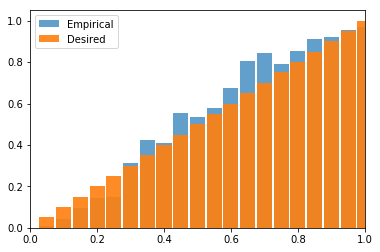

In [33]:
print('Average confidence: ', conf_max.mean().item())
plt.bar(0.05+np.arange(buckets) / buckets, ratio, width=0.045, alpha=0.7)
plt.bar(0.05+np.arange(buckets) / buckets, np.arange(1,1+buckets) / buckets, width=0.045, alpha=0.9)
plt.legend(['Empirical', 'Desired'])
plt.axis([0,1.0,None,None])
plt.show()

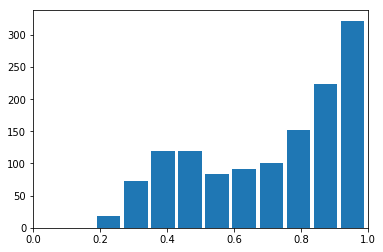

In [318]:
plt.hist((probs.max(1)[0]).detach().numpy(), width=0.07)
plt.axis([0,1.0,None,None])
plt.show()

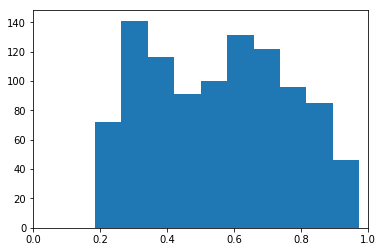

In [58]:
import matplotlib.pyplot as plt
plt.hist(conf_max)
plt.axis([0,1.0,None,None])
plt.show()

### Out-of-distribution nodes

In [34]:
# Loop over classes
total_neighbors = 0
total_features = 0
total_other = 0
total = 0
for n in range(7): # neighbor class
    for m in range(7): # center node class

        # Create connections to nodes
        adj_vec =  torch.eye(adj.shape[0])[(labels == n).nonzero()[4:5]].sum(dim=0).squeeze() # 5 from class 5
        adj_vec = torch.cat((adj_vec, torch.ones(1)))
        adj_vec = (adj_vec / adj_vec.sum()).reshape(-1,1)

        # Modify adjacency matrix
        adj_ood = adj.to_dense()
        adj_ood = torch.cat((torch.cat((adj_ood, adj_vec[:-1]), dim=1), adj_vec.t()), dim=0)
        adj_ood = dense_to_sparse(adj_ood)

        # Features
        feats_ood = torch.cat((feats, feats[labels == m].mean(dim=0, keepdim=True)), dim=0)

        # Print prediction
        probs = torch.softmax(model(feats_ood, adj_ood), dim=1)[-1]

        total_neighbors += probs[n].item()
        total_features  += probs[m].item()
        total_other += probs.sum().item() - probs[n].item() - probs[m].item()
        total += 1


        l = list(probs.detach().numpy())
        l = ' '.join(['{:.4f}%'.format(x * 100) for x in l])
        # print('N = {}, M = {}'.format(n, m), l)

print(i, total_neighbors / total, total_features / total, total_other / total)

1 0.6645285140494911 0.2104721760415301 0.12499929044623764


In [30]:
total_neighbors / total, total_features / total, total_other / total

(tensor(0.6505, grad_fn=<DivBackward0>),
 tensor(0.1910, grad_fn=<DivBackward0>),
 tensor(0.1585, grad_fn=<DivBackward0>))

### Exploring
We explore the degree of uncertainty given to the incorrectly labeled data points. 

In [129]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 5)

In [130]:
# Extract incorrect labels
y_hat_wrong = torch.nn.functional.softmax(output[idx][preds_eq == 0], dim=1)
y_hat_right = torch.nn.functional.softmax(output[idx][preds_eq == 1], dim=1)
# y_wrong = labels[idx][preds_eq == 0]
#y_wrong_onehot = torch.eye(7)[labels[idx][preds_eq == 0]]

In [131]:
# # Some example data points
# print('--- Example 53')
# print('Prediction: ', y_hat_wrong[53].data.numpy())
# print('Label: ', y_wrong[53].item())
# print()
# print('--- Example 33')
# print('Prediction: ', y_hat_wrong[33].data.numpy())
# print('Label: ', y_wrong[33].item())

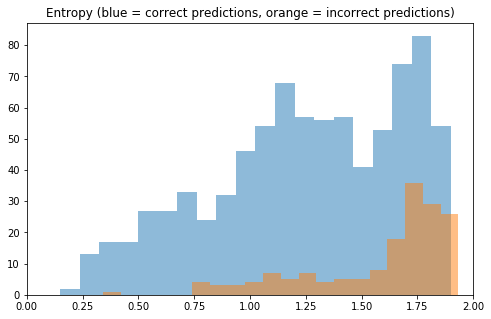

In [142]:
# The amount we are wrong for each example: 
# max predicted (wrong) class probability - the correct class probability
# amt_wrong = y_hat_wrong.max(dim=1)[0] - (y_wrong_onehot * y_hat_wrong).sum(dim=1)

entropy_wrong = -(y_hat_wrong * torch.log(y_hat_wrong)).sum(dim=1)
entropy_right = -(y_hat_right * torch.log(y_hat_right)).sum(dim=1)
plt.hist(entropy_right.detach().cpu().numpy(), bins=20, alpha=0.5)
plt.hist(entropy_wrong.detach().cpu().numpy(), bins=20, alpha=0.5)
plt.xlim(0.0,2.0)
plt.title('Entropy (blue = correct predictions, orange = incorrect predictions)')
plt.show()
# plt.hist(amt_wrong.detach().cpu().numpy(), bins=20)


In [280]:
# # Create connections to nodes
# adj_vec =  torch.eye(adj.shape[0])[(labels == c).nonzero()[0:5]].sum(dim=0).squeeze() # 5 from class 5
# adj_vec += torch.eye(adj.shape[0])[(labels == k).nonzero()[0:1]].sum(dim=0).squeeze() # 5 from class 5
# adj_vec = torch.cat((adj_vec, torch.ones(1)))
# adj_vec = (adj_vec / adj_vec.sum()).reshape(-1,1)

# # Modify adjacency matrix
# adj_ood = adj.to_dense()
# adj_ood = torch.cat((torch.cat((adj_ood, adj_vec[:-1]), dim=1), adj_vec.t()), dim=0)
# adj_ood = dense_to_sparse(adj_ood)len(idx_test)

In [360]:
# # Synthetic
# synthetic = [[1,1,1,1,1,1],
#              [1,1,0,0,0,0],
#              [1,0,1,0,0,0],
#              [1,0,0,1,0,0],
#              [1,0,0,0,1,0],
#              [1,0,0,0,0,1],]
# synthetic = torch.FloatTensor(synthetic)
# synthetic = synthetic / synthetic.sum(dim=1, keepdim=True)
# synthetic = dense_to_sparse(synthetic)

# # Modify features
# neighbor_feats  = feats[labels == n].mean(dim=0, keepdim=True)
# node_feats      = feats[labels == m].mean(dim=0, keepdim=True)
# synthetic_feats = [node_feats] + [neighbor_feats for _ in range(5)]
# synthetic_feats = torch.cat(synthetic_feats, dim=0)


In [ ]:
# PROBS
# conf_max = probs.max(1)[0]
# conf_max_correct = conf_max[probs.max(1)[1] == labels[idx]]
# conf_max_incorrect = conf_max[probs.max(1)[1] != labels[idx]]

# Comment this out if desired
# conf_notmax = (probs * (probs != probs.max(1)[0].reshape(-1,1)).float()).reshape(-1)
# conf_notmax = conf_notmax[conf_notmax.nonzero()]
# conf_max = conf_max.detach().numpy()
# conf_notmax = conf_notmax.detach().numpy()